In [1]:
import xarray as xr
import rasterio as rio
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, gdal_array
import os
import shutil
from glob import glob
from scipy.interpolate import interpn

In [2]:
igram_list = glob('/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/work/merged/interferograms/*')
range_offset_list = glob('/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/offsets/*.tif')
fusion_pair_path = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/fusion_pairs'

In [3]:
# copy all igram pairs to fuse folder
for igram_dir in igram_list:
    shutil.copytree(igram_dir, f'{fusion_pair_path}/{os.path.basename(igram_dir)}_interferogram')

In [3]:
# copy all offset pairs to fuse folder
for range_offset in range_offset_list:
    dates = f'{os.path.basename(range_offset)[5:13]}_{os.path.basename(range_offset)[14:22]}'
    os.makedirs(f'{fusion_pair_path}/{dates}_offset')
    shutil.copy(range_offset, f'{fusion_pair_path}/{dates}_offset/range_offset.tif')

In [37]:
# open insar coherence
cor_fn = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/mintpy_igrams/avgSpatialCoh.h5'
cor_ds = xr.open_dataset(cor_fn)
phony_coherence = 1 - cor_ds.temporalCoherence.values
#phony_coherence = np.where(phony_coherence < 0.5, 0, phony_coherence)

AttributeError: 'Dataset' object has no attribute 'temporalCoherence'

In [39]:
# open insar coherence
t_cor_fn = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/mintpy_igrams/temporalCoherence.h5'
t_cor_ds = xr.open_dataset(t_cor_fn)
t_phony_coherence = 1 - t_cor_ds.temporalCoherence.values
#phony_coherence = np.where(phony_coherence < 0.5, 0, phony_coherence)

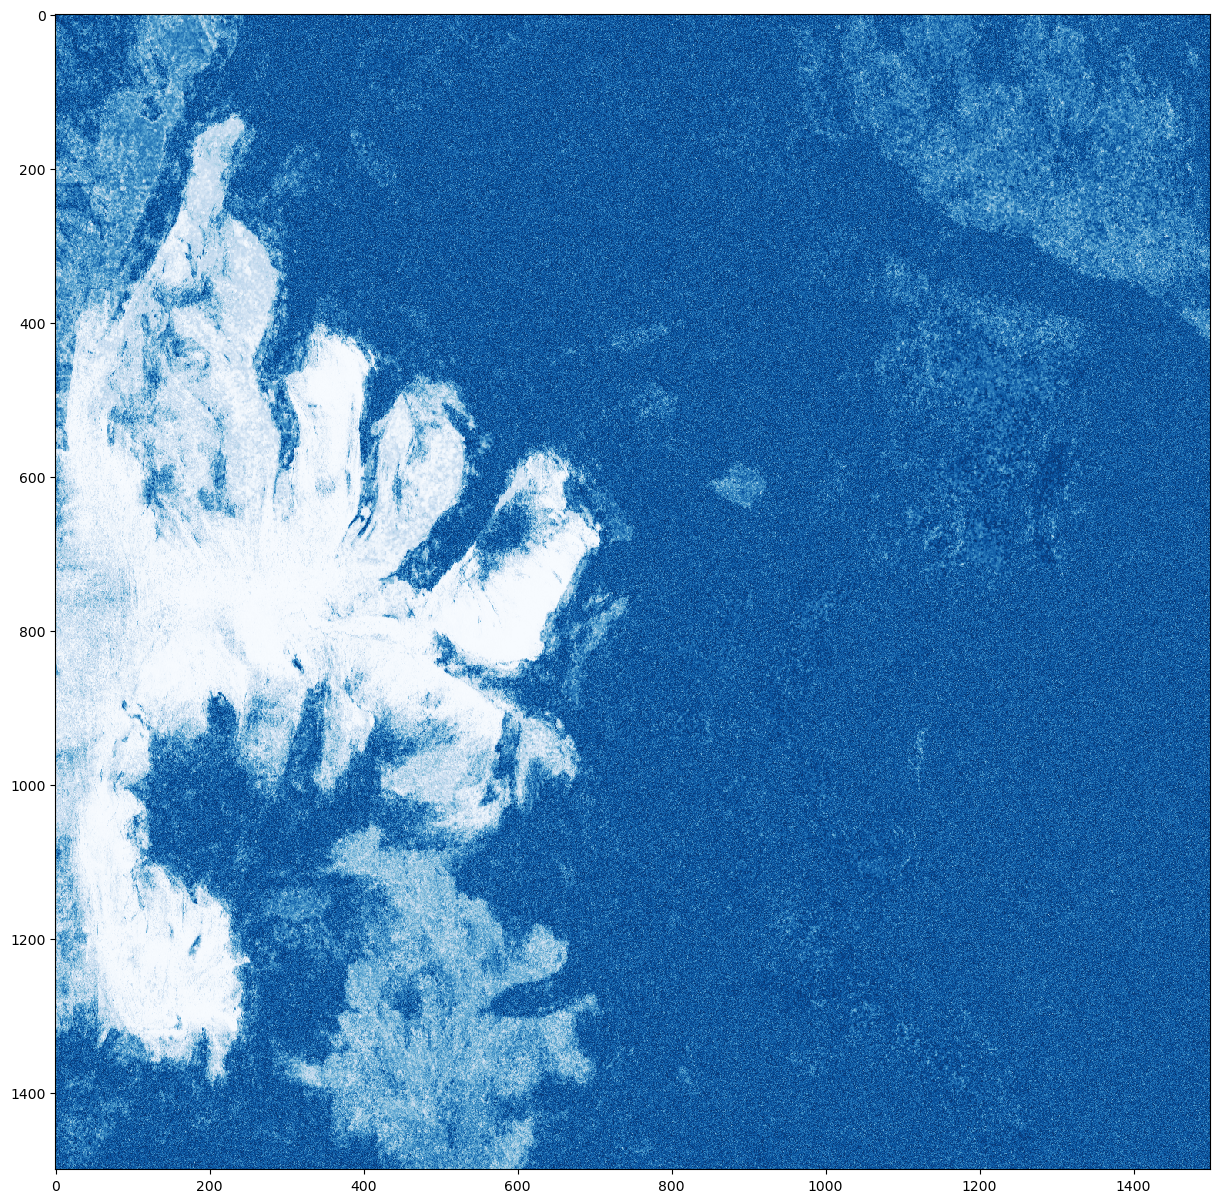

In [41]:
f, ax = plt.subplots(figsize=(15, 15))
ax.imshow(np.flip(t_phony_coherence, 0), cmap='Blues', vmin=0, vmax=1, interpolation='none')

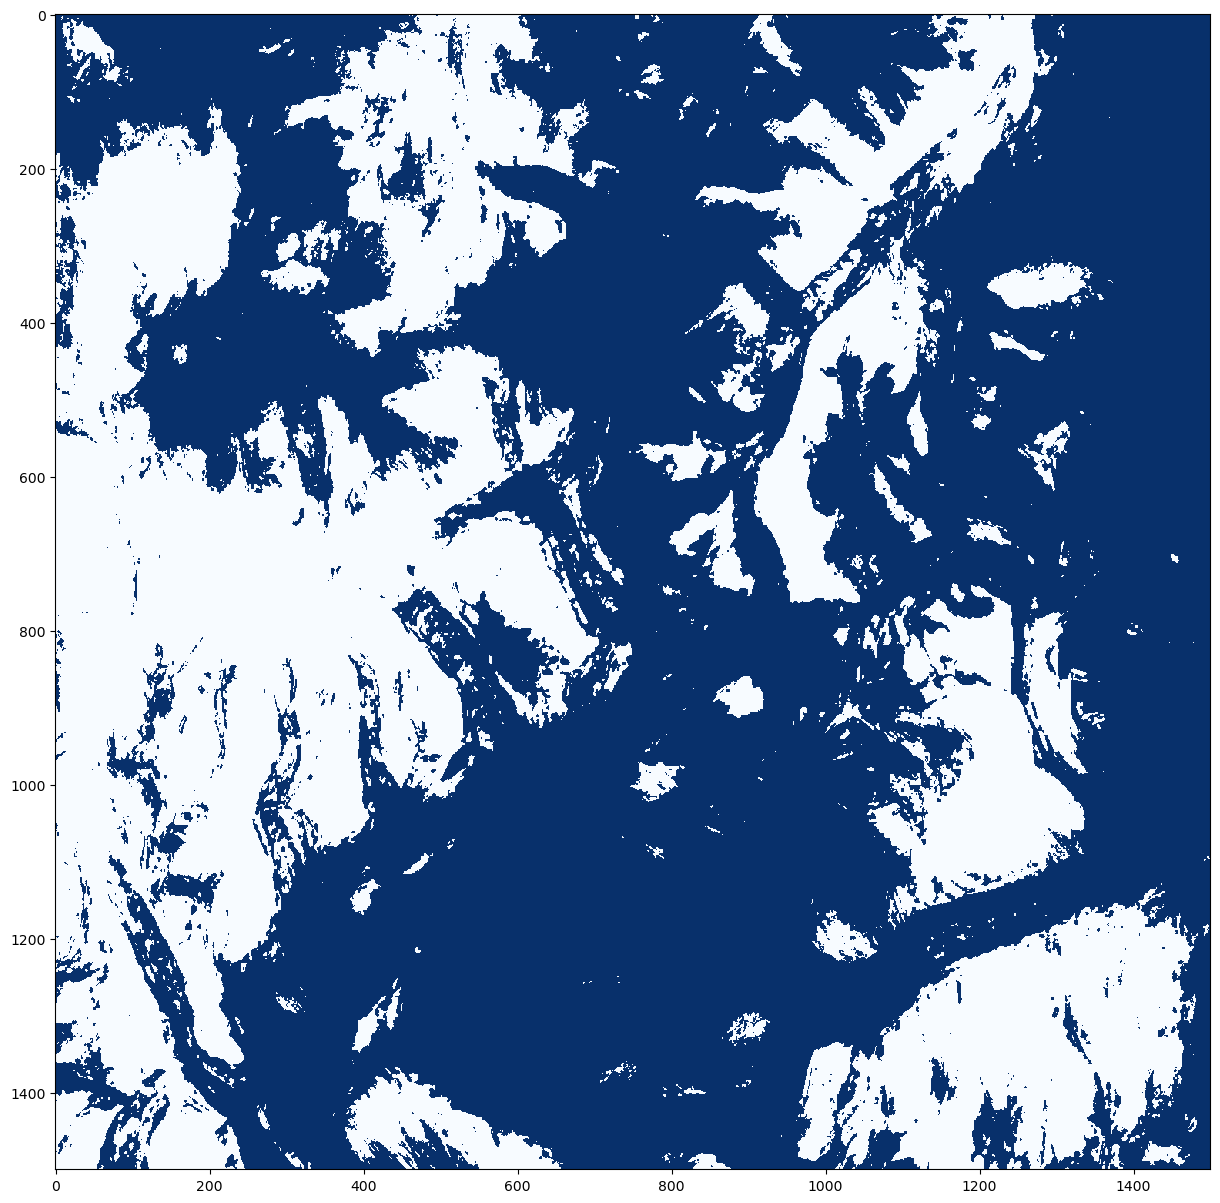

In [33]:
f, ax = plt.subplots(figsize=(15, 15))
ax.imshow(np.where(phony_coherence < 0.5, 0, phony_coherence), cmap='Blues', vmin=0, vmax=0.5, interpolation='none')

In [31]:
offset_dir_list = glob(f'{fusion_pair_path}/*_offset')
#igram_dir = glob(f'{fusion_pair_path}/*_interferogram')[0]

for offset_dir in offset_dir_list:
    os.chdir(offset_dir)
    
    # igram_fn = f'{igram_dir}/filt_fine.int'
    # igram_ds = gdal.Open(igram_fn, gdal.GA_ReadOnly)
    # igram = igram_ds.GetRasterBand(1).ReadAsArray()

    offset_fn = f'{offset_dir}/range_offset.tif'
    offset_ds = gdal.Open(offset_fn, gdal.GA_ReadOnly)
    offset = offset_ds.GetRasterBand(1).ReadAsArray()
    offset = np.nan_to_num(offset, nan=0)

    # non_zero_rows = np.any(igram != 0, axis=1)
    # non_zero_cols = np.any(igram != 0, axis=0)
    # igram_crop = igram[non_zero_rows][:, non_zero_cols]

    # non_zero_rows = np.any(offset != 0, axis=1)
    # non_zero_cols = np.any(offset != 0, axis=0)
    # offset_crop = offset[non_zero_rows][:, non_zero_cols]

    # # Find rows and columns with all zeros and remove them in each direction
    # row_sum = np.sum(igram, axis=1)
    # col_sum = np.sum(igram, axis=0)
    # top_padding = 0
    # bottom_padding = 0
    # left_padding = 0
    # right_padding = 0
    
    # # Determine top padding
    # while row_sum[top_padding] == 0:
    #     top_padding += 1
    
    # # Determine bottom padding
    # while row_sum[-1 - bottom_padding] == 0:
    #     bottom_padding += 1
    
    # # Determine left padding
    # while col_sum[left_padding] == 0:
    #     left_padding += 1
    
    # # Determine right padding
    # while col_sum[-1 - right_padding] == 0:
    #     right_padding += 1

    # # interpolate to match interferogram dimensions
    # x_coords = np.linspace(0, offset_crop.shape[1]-1, offset_crop.shape[1])
    # y_coords = np.linspace(0, offset_crop.shape[0]-1, offset_crop.shape[0])
    
    # # Create a mesh grid for the interferogram dimensions
    # x_coords_new, y_coords_new = np.meshgrid(
    #     np.linspace(x_coords.min(), x_coords.max(), igram_crop.shape[1]),
    #     np.linspace(y_coords.min(), y_coords.max(), igram_crop.shape[0])
    # )
    
    # # Perform bilinear interpolation using scipy.interpolate.interpn
    # offset = interpn((y_coords, x_coords), offset_crop, (y_coords_new, x_coords_new), method="linear")

    offset_phase = offset*(12.5663706/0.05546576)
    # pad to original interferogram dimensions
    #offset_full = np.pad(offset_phase, ((top_padding, bottom_padding), (left_padding, right_padding)), mode='constant')

    offset_aoi = offset_phase[3250:4750, 2600:4100]

    # write cropped speckle tracking displacement
    offset_aoi = np.where(phony_coherence > 0.5, offset_aoi, 0)
    offset_aoi = offset_aoi.astype(np.float32)
    output_file = f'{offset_dir}/phony_filt_fine_aoi_noest.unw' 
    driver_format = "ISCE"    # Specify the GDAL format for the output (GeoTIFF in this example)
    rows, cols = offset_aoi.shape    # Get the number of rows and columns from the NumPy array
    data_type = gdal_array.NumericTypeCodeToGDALTypeCode(offset_aoi.dtype)  # Convert NumPy data type to GDAL data type
    driver = gdal.GetDriverByName(driver_format)
    output_ds = driver.Create(output_file, cols, rows, 1, data_type)
    band = output_ds.GetRasterBand(1)  
    band.WriteArray(offset_aoi)
    output_ds = None

    # # write phony connected components 
    # components = np.ones_like(offset_aoi)
    # output_file = f'{offset_dir}/phony_conn_comp' 
    # driver_format = "ISCE"    # Specify the GDAL format for the output (GeoTIFF in this example)
    # rows, cols = components.shape    # Get the number of rows and columns from the NumPy array
    # data_type = gdal_array.NumericTypeCodeToGDALTypeCode(components.dtype)  # Convert NumPy data type to GDAL data type
    # driver = gdal.GetDriverByName(driver_format)
    # output_ds = driver.Create(output_file, cols, rows, 1, data_type)
    # band = output_ds.GetRasterBand(1)  
    # band.WriteArray(components)
    # output_ds = None

    # write phony coherence 
    #coherence = np.ones_like(offset_aoi)
    output_file = f'{offset_dir}/phony_filt_fine_aoi.cor' 
    driver_format = "ISCE"    # Specify the GDAL format for the output (GeoTIFF in this example)
    rows, cols = phony_coherence.shape    # Get the number of rows and columns from the NumPy array
    data_type = gdal_array.NumericTypeCodeToGDALTypeCode(phony_coherence.dtype)  # Convert NumPy data type to GDAL data type
    driver = gdal.GetDriverByName(driver_format)
    output_ds = driver.Create(output_file, cols, rows, 1, data_type)
    band = output_ds.GetRasterBand(1)  
    band.WriteArray(phony_coherence)
    output_ds = None